In [1]:
import pandas as pd
import glob

# Function to preprocess a single DataFrame
def preprocess_df(filepath):
    df = pd.read_csv(filepath, sep=';', low_memory=False)

    date_col = df["date"]
    for item_idx in range(len(date_col)):
        d_item = date_col[item_idx]
        if isinstance(d_item, str):
            if d_item.split(":")[-1] == "":
                date_col.loc[item_idx] = d_item + "00"
            elif len(d_item.split(":")[-1]) == 1:
                date_col.loc[item_idx] = d_item + "0"

    df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True, format='%d.%m.%y %H:%M:%S:%f')
    df['date'] = df['date'].iloc[:-1]

    df_start_trial = df[df['tagLabel'] == 'Start trial']
    df_start_trial['date_diff'] = df_start_trial.groupby('trialid')['date'].transform(lambda x: x.max() - x.min())
    df_start_trial = df_start_trial.drop_duplicates(subset='trialid', keep='first')
    df_start_trial['date_diff'] = df_start_trial['date_diff'].dt.total_seconds()

    df_start_trial = df_start_trial.loc[df_start_trial['date_diff'] <= 15]
    
    return df_start_trial

# Get a list of csv files
csv_files = glob.glob('G:\Drive partagés\EPFL_Streetlab\Data Participants\EEG Study\Post_2023\Post_2023_Control_Center_Data\*.csv')

# Process each csv file and store the result in a list
dfs = [preprocess_df(f) for f in csv_files]

# Concatenate all the dataframes in the list into a single dataframe
df = pd.concat(dfs, ignore_index=True)



C:\Users\anton\AppData\Local\Temp\ipykernel_8616\2673231765.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_col.loc[item_idx] = d_item + "0"
C:\Users\anton\AppData\Local\Temp\ipykernel_8616\2673231765.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_col.loc[item_idx] = d_item + "00"
C:\Users\anton\AppData\Local\Temp\ipykernel_8616\2673231765.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

C:\Users\anton\AppData\Local\Temp\ipykernel_8616\2673231765.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_start_trial['date_diff'] = df_start_trial.groupby('trialid')['date'].transform(lambda x: x.max() - x.min())
C:\Users\anton\AppData\Local\Temp\ipykernel_8616\2673231765.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_col.loc[item_idx] = d_item + "0"
C:\Users\anton\AppData\Local\Temp\ipykernel_8616\2673231765.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [4]:
import scipy.stats as stats

# Select the 'date_diff' values for each group from the filtered dataframe
df_filtered = df[df['fieldOfView'].isin([20, 45])]
group1 = df_filtered[df_filtered['fieldOfView'] == 20]['date_diff']
group2 = df_filtered[df_filtered['fieldOfView'] == 45]['date_diff']

# Perform the t-test
t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False, nan_policy='omit')

# Print the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_val}')

import numpy as np

# Calculate the means of the two groups
mean1, mean2 = np.mean(group1), np.mean(group2)

# Calculate the variance of the two groups
var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

# Calculate the number of samples in the two groups
n1, n2 = len(group1), len(group2)

# Calculate the pooled standard deviation
pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

# Calculate Cohen's d
d = (mean1 - mean2) / pooled_std

# Print the result
print(f"Cohen's d: {d}")


T-statistic: 2.8248724759950163
P-value: 0.004863599669070963
Cohen's d: 0.19350886436750103


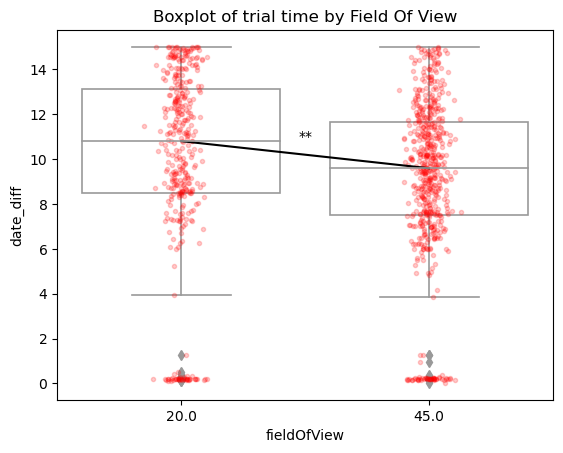

In [6]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Draw the boxplot
ax = sns.boxplot(x=df_filtered['fieldOfView'], y=df_filtered['date_diff'], color='white', linewidth=1.2)

# Define the field of views you are interested in
fovs = [20, 45]

# Add individual data points to the boxplot with reduced size and opacity
for i, fov in enumerate(fovs):
    y = df_filtered.loc[df_filtered['fieldOfView'] == fov, 'date_diff']
    x = np.random.normal(i, 0.04, size=len(y))  # add jitter to the x-coordinate
    plt.plot(x, y, 'r.', alpha=0.2)

plt.title('Boxplot of trial time by Field Of View')

# Get the y-coordinate of the box for each group
y1 = group1.median()
y2 = group2.median()

# Calculate the maximum y value for the annotation line
ymax = max(y1, y2)

# Draw a line between the means of two groups
plt.plot([0, 1], [y1, y2], color='black')

# Draw the text with *** indicating that the difference is significant
if p_val < 0.001:
    plt.text(0.5, ymax, '***', ha='center')
elif p_val < 0.01:
    plt.text(0.5, ymax, '**', ha='center')
elif p_val < 0.05:
    plt.text(0.5, ymax, '*', ha='center')

plt.show()



9.890588235294118
9.128410256410255
10.8
9.59


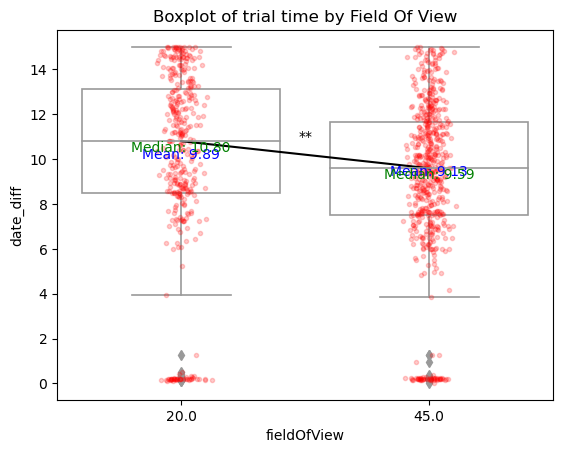

In [11]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Draw the boxplot
ax = sns.boxplot(x=df_filtered['fieldOfView'], y=df_filtered['date_diff'], color='white', linewidth=1.2)

# Define the field of views you are interested in
fovs = [20, 45]

# Add individual data points to the boxplot with reduced size and opacity
for i, fov in enumerate(fovs):
    y = df_filtered.loc[df_filtered['fieldOfView'] == fov, 'date_diff']
    x = np.random.normal(i, 0.04, size=len(y))  # add jitter to the x-coordinate
    plt.plot(x, y, 'r.', alpha=0.2)

# Get the mean and median for each group
mean1 = df_filtered[df_filtered['fieldOfView'] == fovs[0]]['date_diff'].mean()
mean2 = df_filtered[df_filtered['fieldOfView'] == fovs[1]]['date_diff'].mean()
median1 = df_filtered[df_filtered['fieldOfView'] == fovs[0]]['date_diff'].median()
median2 = df_filtered[df_filtered['fieldOfView'] == fovs[1]]['date_diff'].median()

print(mean1)
print(mean2)
print(median1)
print(median2)

plt.title('Boxplot of trial time by Field Of View')

# Calculate the maximum y value for the annotation line
ymax = max(mean1, mean2, median1, median2)

# Draw a line between the means of two groups
plt.plot([0, 1], [median1, median2], color='black')

# Add mean and median to the plot
plt.text(0, mean1, f'Mean: {mean1:.2f}', ha='center', va='bottom', color='blue')
plt.text(1, mean2, f'Mean: {mean2:.2f}', ha='center', va='bottom', color='blue')
plt.text(0, median1, f'Median: {median1:.2f}', ha='center', va='top', color='green')
plt.text(1, median2, f'Median: {median2:.2f}', ha='center', va='top', color='green')

# Draw the text with *** indicating that the difference is significant
if p_val < 0.001:
    plt.text(0.5, ymax, '***', ha='center')
elif p_val < 0.01:
    plt.text(0.5, ymax, '**', ha='center')
elif p_val < 0.05:
    plt.text(0.5, ymax, '*', ha='center')

plt.show()
